In [13]:
from __future__ import division, print_function
from math import floor
import numpy as np
import matplotlib.pyplot as plt
import sys
import scipy.stats as stats
import lmfit
import time
import math
from scipy.signal import savgol_filter

In [45]:
def RisingEdge(signal):
    sig = savgol_filter(signal, 3, 1) # Savitzky-Golay filter smooths signal to get accurate vlaue for max val
    maxval = np.amax(sig)
    minval = np.amin(sig)
    if np.abs(maxval) >= np.abs(minval): # positive signal
        tenval = maxval* 0.01 # using t99- t01
        ninetyval = maxval * 0.99
    
        tenindex = 0
        ninetyindex = 0
        for i in range(0, np.argmax(signal), 1): # picks out last value before t01
            if signal[i] <= tenval:
                tenindex = i
        for i in range(tenindex, len(signal), 1): # picks out first value after t99
             if signal[i] >= ninetyval:
                ninetyindex = i
                break  
                
    elif np.abs(maxval) < np.abs(minval): # negative
        tenval = minval* 0.01 # using t99- t01
        ninetyval = minval * 0.99
        
        tenindex = 0
        ninetyindex = 0
        for i in range(0, np.argmin(signal), 1): # picks out last value before t01
            if signal[i] >= tenval:
                tenindex = i
        for i in range(tenindex, np.argmin(signal) + 5, 1): # picks out first value after t99
             if signal[i] <= ninetyval:
                ninetyindex = i
                break           
    else:
        print('ERROR')
        
    if tenindex == ninetyindex:
        print(tenval)
        print(signal[tenindex])
        print(ninetyval)
        print(signal[ninetyindex])
        plt.plot(signal, 'o')
        plt.plot(tenindex, signal[tenindex], 'dr')
        plt.plot(ninetyindex, signal[ninetyindex], 'sr')
        plt.show()
        print('ERROR2')
        
    signal = signal[tenindex:ninetyindex] # cut out t99-t01 portion and pad the rest with zeros to get it to same length (301 samples)
    length = 301 - len(signal)
    z = np.zeros(length)
    signal = np.concatenate((signal,z))
    return signal

In [46]:
def RisingEdgeTest(signal):
    sig = np.abs(signal)
    sig = savgol_filter(signal, 3, 1) # Savitzky-Golay filter smooths signal to get accurate vlaue for max val
    maxval = np.amax(sig)
    minval = np.amin(sig)  
    tenval = maxval* 0.01 # using t99- t01
    ninetyval = maxval * 0.99
    sig = np.abs(signal)
    tenindex = 0
    ninetyindex = 0
    for i in range(0, np.argmax(signal), 1): # picks out last value before t01
        if signal[i] <= tenval:
            tenindex = i
    for i in range(tenindex, len(signal), 1): # picks out first value after t99
        if signal[i] >= ninetyval:
            ninetyindex = i
            break  
        
    signal = signal[tenindex:ninetyindex] # cut out t99-t01 portion and pad the rest with zeros to get it to same length (301 samples)
    length = 301 - len(signal)
    z = np.zeros(length)
    signal = np.concatenate((signal,z))
    return signal

In [47]:
def ImportBaseSignals():
    data = np.zeros((300, 12, 301 * 6)) #15.0 mm/ 0.05 = 300 samples in z, 12 in x, 301 samples per signal
    for i in range(0, 300*12, 1):
        i = int(i)
        filename = "./datafiles/Strip_SS_" + str(i) + ".txt"
        rawdata = np.genfromtxt(filename, skip_header=1)
        #print(rawdata.shape)
        strip0 = rawdata[:,7:8] # strip 1 # CHECK COL NUM
        strip1 = rawdata[:,8:9] # strip 2
        strip2 = rawdata[:,9:10] # strip 3
        strip3 = rawdata[:,12:13] # strip 6
        strip4 = rawdata[:,13:14] # strip 7
        strip5 = rawdata[:,14:15] # strip 8  # 7 misc + 10 timing
        
        allstrips = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        row = int(math.floor(i / 12))
        col = int(i % 12)
        #print(row, col)
        data[row, col] = allstrips # row, column
    return data

def ImportBaseRisingEdgeSignals():
    data = np.zeros((300, 12, 301 * 6)) #150 in z, 4 strips * 301 samples
    for i in range(0, 300*12, 1):
        i = int(i)
        filename = "./datafiles/Strip_SS_" + str(i) + ".txt"
        rawdata = np.genfromtxt(filename, skip_header=1)
        
        strip0 = rawdata[:,7:8] # strip 1
        strip1 = rawdata[:,8:9] # strip 2
        strip2 = rawdata[:,9:10] # strip 3
        strip3 = rawdata[:,12:13] # strip 6
        strip4 = rawdata[:,13:14] # strip 7
        strip5 = rawdata[:,14:15] # strip 8 
        
        strip0=strip0.flatten(order='C') # reduce to 1D array to pass to RisingEdge function
        strip1=strip1.flatten(order='C')
        strip2=strip2.flatten(order='C')
        strip3=strip3.flatten(order='C')
        strip4=strip4.flatten(order='C')
        strip5=strip5.flatten(order='C')
        
        strip0 = RisingEdge(strip0)
        strip1 = RisingEdge(strip1)
        strip2 = RisingEdge(strip2)
        strip3 = RisingEdge(strip3)
        strip4 = RisingEdge(strip4)
        strip5 = RisingEdge(strip5)
        
        allstrips = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        row = int(math.floor(i / 12))
        col = int(i % 12)
        #print(row, col)
        data[row, col] = allstrips # row, column
    return data

import simulated data as 'base' signals

In [48]:
base_data = ImportBaseSignals()
base_re_data = ImportBaseRisingEdgeSignals()

In [49]:
base_data.shape
base_re_data.shape

(300, 12, 1806)

plot signals to check the number of collecting strips

(300, 12, 1806)


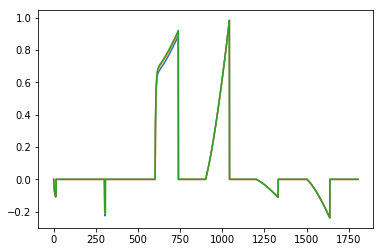

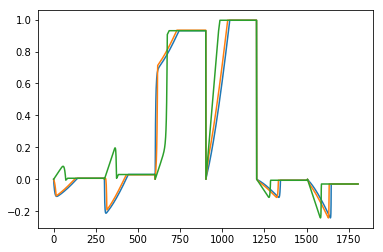

In [50]:
print(base_re_data.shape)
#plt.plot(base_data[0][0], label ='0')
#plt.plot(base_data[0][1], label ='1')
#plt.plot(base_data[0][2], label ='2')
plt.plot(base_re_data[0][3], label ='3')
plt.plot(base_re_data[0][4], label ='4')
plt.plot(base_re_data[0][5], label ='5')
plt.show()

plt.plot(base_data[0][5], label ='5')
plt.plot(base_data[17][5], label ='5')
plt.plot(base_data[100][5], label ='5')
plt.show()

In [54]:
def moving_avg_filter(x):
    x = x.flatten()
    N = 20
    length = len(x)
    # print(len(x))
    x = np.convolve(x, np.ones((N,))/N, mode='same')
    x[length -1] = x[length -2]
    # print(len(x))
    return x

def add_noise(sig, dV):
    noise = np.random.normal(0,dV,len(sig))
    sig = sig + noise
    return sig

tau = 4400
def add_exp_decay(sig):
    for i in range(0, len(sig) ,1):
        sig[i] = sig[i] * np.exp(-i/tau)
    return sig

def baseline_correction(data):
    n_data = len(data)
    baseline_correction_value = np.mean(data[0:99])
    for i in range(0, n_data, 1):
        data[i] = data[i] - baseline_correction_value
    return data

def decay_correction(data, tau):
    decay_corrected = []
    decay_correction = []
    for i in range(1, len(data), 1):
        decay = np.sum(data[1:i-1])
        decay_correction.append(decay)
        decay_corrected.append(data[i] + decay / tau)
    decay_corrected.append(data[i-1])
    return decay_corrected

In [77]:
def MakeTestSignal(rawdata):
        dV = 5/200
        
        strip0 = rawdata[0:301] # strip 1
        strip1 = rawdata[301:602] # strip 2
        strip2 = rawdata[602:903] # strip 3
        strip3 = rawdata[903:1204]# strip 6
        strip4 = rawdata[1204:1505] # strip 7
        strip5 = rawdata[1505:1806] # strip 8
        
        strip0=strip0.flatten(order='C')
        strip1=strip1.flatten(order='C')
        strip2=strip2.flatten(order='C')
        strip3=strip3.flatten(order='C')
        strip4=strip4.flatten(order='C')
        strip5=strip5.flatten(order='C')
         
        strip0 = moving_avg_filter(strip0) 
        strip0 = moving_avg_filter(strip0)
        strip0 = add_noise(strip0, dV)
        
        strip1 = moving_avg_filter(strip1)
        strip1 = moving_avg_filter(strip1)
        #strip1 = add_noise(strip1, dV)

        strip2 = moving_avg_filter(strip2)
        strip2 = moving_avg_filter(strip2)
        #strip2 = add_noise(strip2, dV)

        strip3 = moving_avg_filter(strip3)
        strip3 = moving_avg_filter(strip3)
       # strip3 = add_noise(strip3, dV)

        strip4 = moving_avg_filter(strip4)
        strip4 = moving_avg_filter(strip4)
        #strip4 = add_noise(strip4, dV)

        strip5 = moving_avg_filter(strip5)
        strip5 = moving_avg_filter(strip5)
        #strip5 = add_noise(strip5, dV)
        
        strip0 = add_noise(strip0, dV)
        strip1 = add_noise(strip1, dV)
        strip2 = add_noise(strip2, dV)
        strip3 = add_noise(strip3, dV)
        strip4 = add_noise(strip4, dV)
        strip5 = add_noise(strip5, dV)
        
        allstrips = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()

        return allstrips

def MakeTestRisingEdgeSignal(rawdata):
        dV = 5/200
        
        strip0 = rawdata[0:301] # strip 1
        strip1 = rawdata[301:602] # strip 2
        strip2 = rawdata[602:903] # strip 3
        strip3 = rawdata[903:1204]# strip 6
        strip4 = rawdata[1204:1505] # strip 7
        strip5 = rawdata[1505:1806] # strip 8
        
        strip0=strip0.flatten(order='C')
        strip1=strip1.flatten(order='C')
        strip2=strip2.flatten(order='C')
        strip3=strip3.flatten(order='C')
        strip4=strip4.flatten(order='C')
        strip5=strip5.flatten(order='C')
        
        strip0 = moving_avg_filter(strip0)
        strip0 = moving_avg_filter(strip0)
        #strip0 = add_noise(strip0, dV)
        
        strip1 = moving_avg_filter(strip1)
        strip1 = moving_avg_filter(strip1)
        #strip1 = add_noise(strip1, dV)

        strip2 = moving_avg_filter(strip2)
        strip2 = moving_avg_filter(strip2)
        #strip2 = add_noise(strip2, dV)

        strip3 = moving_avg_filter(strip3)
        strip3 = moving_avg_filter(strip3)
       # strip3 = add_noise(strip3, dV)

        strip4 = moving_avg_filter(strip4)
        strip4 = moving_avg_filter(strip4)
        #strip4 = add_noise(strip4, dV)

        strip5 = moving_avg_filter(strip5)
        strip5 = moving_avg_filter(strip5)
        #strip5 = add_noise(strip5, dV)
        
        strip0 = RisingEdge(strip0)
        strip1 = RisingEdge(strip1)
        strip2 = RisingEdge(strip2)
        strip3 = RisingEdge(strip3)
        strip4 = RisingEdge(strip4)
        strip5 = RisingEdge(strip5)
        
        strip0 = add_noise(strip0, dV)
        strip1 = add_noise(strip1, dV)
        strip2 = add_noise(strip2, dV)
        strip3 = add_noise(strip3, dV)
        strip4 = add_noise(strip4, dV)
        strip5 = add_noise(strip5, dV)
        
        allstrips = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        
        return allstrips


####

def MakeTestSignals():
    data = np.zeros((300, 12, 301 * 6)) #300 in z, 12 in x, 301 samples per signal, same as adl3 simulated data
    dV = 5/200 # the stdev of the noise in charge units -> 5kev * (1 [au] / 200 keV) = 5/200 [au]
    for i in range(0, 300*12, 1):
        i = int(i)
        filename = "./datafiles/Strip_SS_" + str(i) + ".txt"
        rawdata = np.genfromtxt(filename, skip_header=1)
        
        strip0 = rawdata[:,7:8] # strip 1
        strip1 = rawdata[:,8:9] # strip 2
        strip2 = rawdata[:,9:10] # strip 3
        strip3 = rawdata[:,12:13] # strip 6
        strip4 = rawdata[:,13:14] # strip 7
        strip5 = rawdata[:,14:15] # strip 8
        
        strip0=strip0.flatten(order='C')
        strip1=strip1.flatten(order='C')
        strip2=strip2.flatten(order='C')
        strip3=strip3.flatten(order='C')
        strip4=strip4.flatten(order='C')
        strip5=strip5.flatten(order='C')
         
        strip0 = moving_avg_filter(strip0) 
        strip0 = moving_avg_filter(strip0)
        strip0 = add_noise(strip0, dV)
        
        strip1 = moving_avg_filter(strip1)
        strip1 = moving_avg_filter(strip1)
        #strip1 = add_noise(strip1, dV)

        strip2 = moving_avg_filter(strip2)
        strip2 = moving_avg_filter(strip2)
        #strip2 = add_noise(strip2, dV)

        strip3 = moving_avg_filter(strip3)
        strip3 = moving_avg_filter(strip3)
       # strip3 = add_noise(strip3, dV)

        strip4 = moving_avg_filter(strip4)
        strip4 = moving_avg_filter(strip4)
        #strip4 = add_noise(strip4, dV)

        strip5 = moving_avg_filter(strip5)
        strip5 = moving_avg_filter(strip5)
        #strip5 = add_noise(strip5, dV)
        
        strip0 = add_noise(strip0, dV)
        strip1 = add_noise(strip1, dV)
        strip2 = add_noise(strip2, dV)
        strip3 = add_noise(strip3, dV)
        strip4 = add_noise(strip4, dV)
        strip5 = add_noise(strip5, dV)
        
        allstrips = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        row = int(i / 12)
        col = int(i % 12)
        data[row, col] = allstrips # row, column
        #data[i] = allstrips 
    return data

def MakeTestRisingEdgeSignals():
    data = np.zeros((300, 12, 301 * 6))
    dV = 5/200
    for i in range(0, 300 * 12, 1):
        i = int(i)
        filename = "./datafiles/Strip_SS_" + str(i) + ".txt"
        rawdata = np.genfromtxt(filename, skip_header=1)
        
        strip0 = rawdata[:,7:8] # strip 1 
        strip1 = rawdata[:,8:9] # strip 2
        strip2 = rawdata[:,9:10] # strip 3
        strip3 = rawdata[:,12:13] # strip 6
        strip4 = rawdata[:,13:14] # strip 7
        strip5 = rawdata[:,14:15] # strip 8
        
        strip0=strip0.flatten(order='C')
        strip1=strip1.flatten(order='C')
        strip2=strip2.flatten(order='C')
        strip3=strip3.flatten(order='C')
        strip4=strip4.flatten(order='C')
        strip5=strip5.flatten(order='C')
        
        strip0 = moving_avg_filter(strip0)
        strip0 = moving_avg_filter(strip0)
        #strip0 = add_noise(strip0, dV)
        
        strip1 = moving_avg_filter(strip1)
        strip1 = moving_avg_filter(strip1)
        #strip1 = add_noise(strip1, dV)

        strip2 = moving_avg_filter(strip2)
        strip2 = moving_avg_filter(strip2)
        #strip2 = add_noise(strip2, dV)

        strip3 = moving_avg_filter(strip3)
        strip3 = moving_avg_filter(strip3)
       # strip3 = add_noise(strip3, dV)

        strip4 = moving_avg_filter(strip4)
        strip4 = moving_avg_filter(strip4)
        #strip4 = add_noise(strip4, dV)

        strip5 = moving_avg_filter(strip5)
        strip5 = moving_avg_filter(strip5)
        #strip5 = add_noise(strip5, dV)
        
        strip0 = RisingEdge(strip0)
        strip1 = RisingEdge(strip1)
        strip2 = RisingEdge(strip2)
        strip3 = RisingEdge(strip3)
        strip4 = RisingEdge(strip4)
        strip5 = RisingEdge(strip5)
        
        strip0 = add_noise(strip0, dV)
        strip1 = add_noise(strip1, dV)
        strip2 = add_noise(strip2, dV)
        strip3 = add_noise(strip3, dV)
        strip4 = add_noise(strip4, dV)
        strip5 = add_noise(strip5, dV)
        
        allstrips = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        
        row = int(i / 12)
        col = int(i % 12)
        data[row, col] = allstrips # row, column
        #data[i] = allstrips 
    return data

make test signals (base signals but with blurring and noise added)

In [78]:
test_data = MakeTestSignals()
test_re_data = MakeTestRisingEdgeSignals()

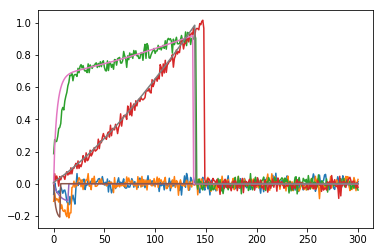

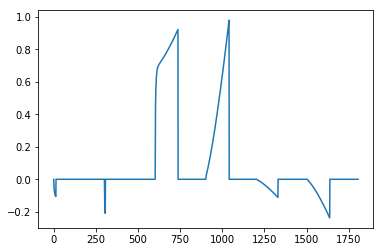

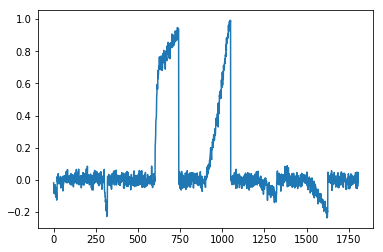

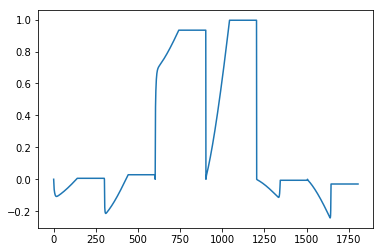

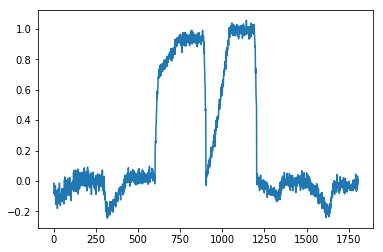

In [57]:
plt.plot(test_re_data[0][5][0:301]) # strip 0
plt.plot(test_re_data[0][5][301:602]) # strip 1
plt.plot(test_re_data[0][5][602:903]) # strip 2
plt.plot(test_re_data[0][5][903:1204]) # strip 3
plt.plot(base_re_data[0][5][0:301], '-')
plt.plot(base_re_data[0][5][301:602], '-')
plt.plot(base_re_data[0][5][602:903], '-')
plt.plot(base_re_data[0][5][903:1204], '-')
plt.show()
plt.plot(base_re_data[2][5], '-')
plt.show()
plt.plot(test_re_data[2][5])
plt.show()
plt.plot(base_data[2][5], '-')
plt.show()
plt.plot(test_data[2][5])
plt.show()
#plt.plot(base_data[2][0], '-')
#plt.plot(test_data[2][0])
#plt.show()

In [58]:
def calc_pos_res(Xi2): # FWHM
    d = 0.05 # in mm, distance btwn points simulated in ADL3
    interaction_energy = 200.0 # keV
    SNR = float(interaction_energy) / 5.0
    dx = ((2.354 * d / SNR)  * (1/np.sqrt(Xi2)))
    #dx = round(dx, 15)
    return dx

In [59]:
def Chi2Single(sig_ref, sig_raw, plot=True):
    sigma = 5/200
    # chi2_values = []
    # amp = np.amax(sig_raw)
    
    strip0_ref = sig_ref[0:301] #splitting apart signals to do shifting (currently excluded)
    strip1_ref = sig_ref[301:602]
    strip2_ref = sig_ref[602:903]
    strip3_ref = sig_ref[903:1204]
    strip4_ref = sig_ref[1204:1505]
    strip5_ref = sig_ref[1505:1806]
        
    strip0 = sig_raw[0:301]
    strip1 = sig_raw[301:602]
    strip2 = sig_raw[602:903]
    strip3 = sig_raw[903:1204]
    strip4 = sig_raw[1204:1505]
    strip5 = sig_raw[1505:1806]
        
   # strip0, chi2 = shift_signal(strip0_ref, strip0) # does time and amplitude
   # strip1, chi2 = shift_signal(strip1_ref, strip1)
   # strip2, chi2 = shift_signal(strip2_ref, strip2) 
   # strip3, chi2 = shift_signal(strip3_ref, strip3) 
   # strip4, chi2 = shift_signal(strip4_ref, strip4) 
   # strip5, chi2 = shift_signal(strip5_ref, strip5)
        
    sig = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        
    chi_squared = np.sum(((sig_ref-sig)/(np.sqrt(2) * sigma))**2)
    #chi_squared = np.round(chi_squared, 10)
        
    if plot == True:
            plt.figure(1)
            plt.plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
            plt.plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
            plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
            plt.text(0, 0.1, chi_squared) 
            plt.legend()
            plt.savefig('test1.pdf')
            plt.show()
            
    # print('chi2 ', chi2)
    posres = calc_pos_res(chi_squared)
    # print('posres ', posres)
    
    return posres, chi_squared 

In [60]:
def Chi2SingleTest(sig_ref, sig_raw, plot=True): # same as above function Chi2SignleTest, just used for testing diff things
    # chi2_values = []
    # amp = np.amax(sig_raw)
    # sig_raw = sig_raw / amp # normalize input signal
    
    strip0_ref = sig_ref[0:301]
    strip1_ref = sig_ref[301:602]
    strip2_ref = sig_ref[602:903]
    strip3_ref = sig_ref[903:1204]
    strip4_ref = sig_ref[1204:1505]
    strip5_ref = sig_ref[1505:1806]
        
    strip0 = sig_raw[0:301]
    strip1 = sig_raw[301:602]
    strip2 = sig_raw[602:903]
    strip3 = sig_raw[903:1204]
    strip4 = sig_raw[1204:1505]
    strip5 = sig_raw[1505:1806]
        
   # strip0, chi2 = shift_signal(strip0_ref, strip0) # does time and amplitude
   # strip1, chi2 = shift_signal(strip1_ref, strip1)
   # strip2, chi2 = shift_signal(strip2_ref, strip2)
   # strip3, chi2 = shift_signal(strip3_ref, strip3) 
   # strip4, chi2 = shift_signal(strip4_ref, strip4) 
   # strip5, chi2 = shift_signal(strip5_ref, strip5) 
        
    sig = np.concatenate((strip0, strip1, strip2, strip3, strip4, strip5)).flatten()
        
    #chi_squared = np.sum(((sig_ref-sig)/(np.sqrt(2) * sigma))**2)
    #chi_squared = np.round(chi_squared, 5)

    chi2 = 0
    for i in range(0, len(sig_ref),1):
        #print(sig[i]- ref_sig[i])
        dsig = (sig[i]- ref_sig[i])**2
        #print('d',dsig)
        sigma = float(5)/float(200)
        sigmasq = 2 * (sigma**2)
        #print('r', (float(dsig) / float(sigmasq)))
        chi2 = chi2 + (float(dsig) / float(sigmasq))
        #print('c', chi2)
    #chi2 = round(chi2, 20)
    #print('her')
    #print(chi2)
    SNR = 200/5
    posres = 2.354 * 0.05 * (1/SNR) * (1/(np.sqrt(chi2)))
    #posres = round(pos,15)
        
    if plot == True:
            plt.figure(1)
            plt.plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
            plt.plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
            plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
            plt.text(0, 0.1, chi2) 
            plt.legend()
            #plt.savefig('test1.pdf')
            plt.show()
            
    # print('chi2 ', chi2)
    #posres = calc_pos_res(chi_squared)
    # print('posres ', posres)
    
    return posres, chi2

test signal shifting (currently not implemented, ignore this)

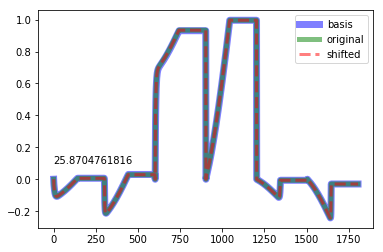

chi2:  25.8704761816
pos:  0.000578514515402


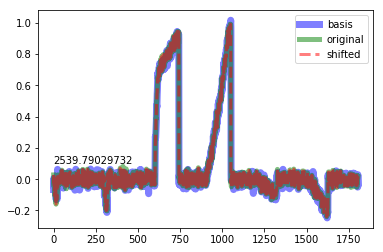

chi2:  2539.79029732
pos:  5.83871855876e-05


In [61]:
ref_sig = base_data[0, 5]
raw_sig = base_data[1, 5]
pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=True)
print('chi2: ',chi2)
print('pos: ', pos)

ref_sig = test_re_data[0, 5]
raw_sig = test_re_data[1, 5]
pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=True)
print('chi2: ',chi2)
print('pos: ', pos)


calc chi2 and position res for central strip (column 5 in data matrix)

In [62]:
chi_2_vals = []
z_pos_vals = [] 
z_chi_sq = []
ref_sig = base_data[149, 5]
for i in range(0, 299):
    raw_sig = base_data[i,5]
    pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
    chi_2_vals.append(chi2)
    z_pos_vals.append(pos)
    z_chi_sq.append(chi2)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


using full signals (not t99-t01), base signals only (no noise/ blurring)

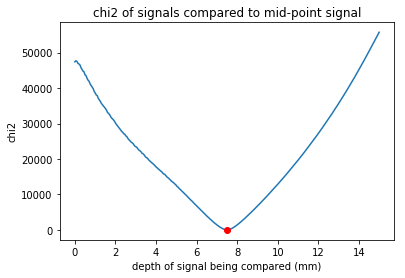

In [63]:
#print(z_chi_sq)
xvals = np.linspace(0, 15, 299)
plt.title('chi2 of signals compared to mid-point signal')
plt.ylabel('chi2')
plt.xlabel('depth of signal being compared (mm)')
plt.plot(xvals, z_chi_sq, '')
plt.plot(xvals[149],z_chi_sq[149], 'ro')
#plt.savefig('./chi2_full.png')
plt.show()

using full signal (not t99-t01), with noise, blurring

In [64]:
chi_2_vals = []
z_pos_vals = [] 
z_chi_sq = []
ref_sig = test_data[149, 5]
for i in range(0, 299):
    raw_sig = test_data[i,5]
    pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
    chi_2_vals.append(chi2)
    z_pos_vals.append(pos)
    z_chi_sq.append(chi2)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


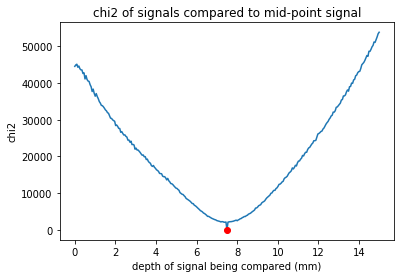

In [65]:
xvals = np.linspace(0, 15, 299)
plt.title('chi2 of signals compared to mid-point signal')
plt.ylabel('chi2')
plt.xlabel('depth of signal being compared (mm)')
plt.plot(xvals, z_chi_sq, '')
plt.plot(xvals[149],z_chi_sq[149], 'ro')
plt.savefig('./chi2_full.png')
plt.show()

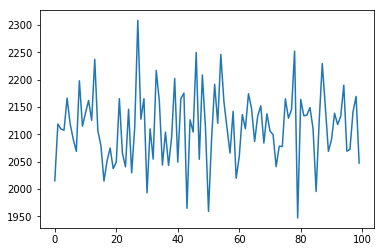

2113.90561226


In [85]:
chi_2_vals = []
z_pos_vals = [] 
z_chi_sq = []
ref_sig = test_data[149, 5]
for i in range(0, 100):
    raw_sig = MakeTestSignal(base_data[149,5])
    pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
    chi_2_vals.append(chi2)
    z_pos_vals.append(pos)
    z_chi_sq.append(chi2)
plt.plot(z_chi_sq)
plt.show()
print(np.mean(z_chi_sq))

In [ ]:
re_chi_2_vals = []
re_z_pos_vals = [] 
re_z_chi_sq = []
ref_sig = base_re_data[149, 5]
for i in range(0, 299):
    raw_sig = base_re_data[i,5]
    pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
    re_chi_2_vals.append(chi2)
    re_z_pos_vals.append(pos)
    re_z_chi_sq.append(chi2)

using (t99-t01), no noise/blurring

In [ ]:
#print(z_chi_sq)
xvals = np.linspace(0, 15, 299)
print(len(xvals))
print(len(re_z_chi_sq))
plt.title('chi2 of signals compared to mid-point signal')
plt.ylabel('chi2')
plt.xlabel('depth of signal being compared (mm)')
plt.plot(xvals, re_z_chi_sq, '')
plt.plot(xvals[149],re_z_chi_sq[149], 'ro')
plt.savefig('./chi2.png')
plt.show()

using (t99-t01), with noise, blurring

In [ ]:
re_chi_2_vals = []
re_z_pos_vals = [] 
re_z_chi_sq = []
ref_sig = test_re_data[149, 5]
for i in range(0, 299):
    raw_sig = test_re_data[i,5]
    pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
    re_chi_2_vals.append(chi2)
    re_z_pos_vals.append(pos)
    re_z_chi_sq.append(chi2)

In [ ]:
#print(z_chi_sq)
xvals = np.linspace(0, 15, 299)
print(len(xvals))
print(len(re_z_chi_sq))
plt.title('chi2 of signals compared to mid-point signal')
plt.ylabel('chi2')
plt.xlabel('depth of signal being compared (mm)')
plt.plot(xvals, re_z_chi_sq, '')
plt.plot(xvals[149],re_z_chi_sq[149], 'ro')
plt.savefig('./chi2.png')
plt.show()

In [ ]:
chi_2_vals = []
z_pos_vals = [] 
z_chi_sq = []
#print(pos_vals)
#for i in range(0, len(base_data)):
ref_sig = base_re_data[149, 5]
for i in range(0, 299):
    #print(i)
    ref_sig = base_re_data[i, 5]
    raw_sig = base_re_data[i + 1,5]
    pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
    #print(pos)
    #print(chi2)
    chi_2_vals.append(chi2)
    z_pos_vals.append(pos)
    z_chi_sq.append(chi2)
#print(np.mean(z_pos_vals))
#print()


#print(z_chi_sq)
xvals = np.linspace(0, 15, 299)
print(len(xvals))
print(len(z_chi_sq))
plt.title('chi2 of signals z, z-1')
plt.ylabel('chi2')
plt.xlabel('depth of signal being compared (mm)')
plt.plot(xvals, z_chi_sq, '')
#plt.plot(xvals[149],z_chi_sq[149], 'ro')
#plt.savefig('./chi2.png')
plt.show()

In [145]:
# Z and Z + 1
re_chi_2_vals = []
re_z_pos_vals = np.zeros((299, 12))
re_z_chi_sq = np.zeros((299, 12))
#print(pos_vals)
#for i in range(0, len(base_data)):
for j in range(0, 12):
    for i in range(0, 299 - 1):
        ref_sig = base_re_data[i, j]
        raw_sig = base_re_data[i + 1,j]
        pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
        re_chi_2_vals.append(chi2)
        re_z_pos_vals[i, j] = pos
        re_z_chi_sq[i, j] = chi2
print(np.mean(re_z_pos_vals))

# Z and Z + 1
chi_2_vals = []
z_pos_vals = np.zeros((299, 12))
z_chi_sq = np.zeros((299, 12))
#print(pos_vals)
#for i in range(0, len(base_data)):
for j in range(0, 12):
    for i in range(0, 299 - 1):
        ref_sig = base_data[i, j]
        raw_sig = base_data[i + 1,j]
        pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=False)
        chi_2_vals.append(chi2)
        z_pos_vals[i, j] = pos
        z_chi_sq[i, j] = chi2
print(np.mean(z_pos_vals))

0.000182587864644
0.000644253305791


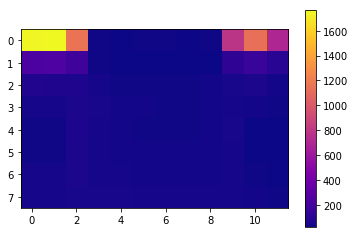

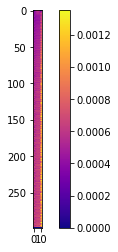

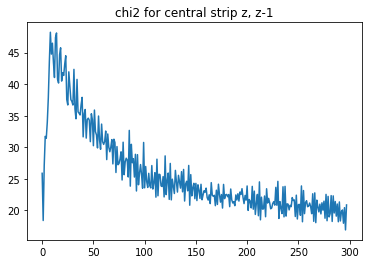

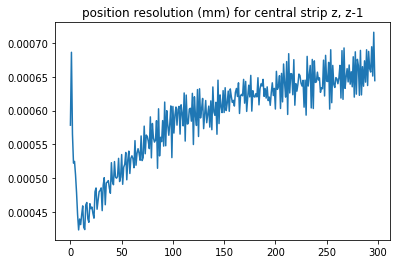

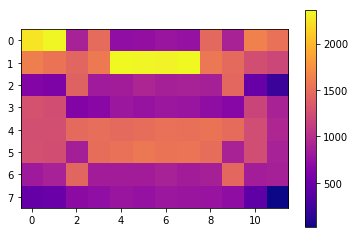

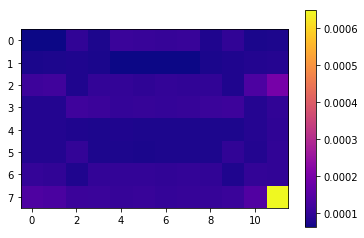

In [146]:
plt.imshow( z_chi_sq[0:8,], cmap='plasma', interpolation='none')
plt.colorbar()
#plt.savefig('./z_xi_png.pdf')
plt.show()

plt.imshow( z_pos_vals[0:300,], cmap='plasma', interpolation='none')
plt.colorbar()
#plt.savefig('./z_pos_png.pdf')
plt.show()

plt.title('chi2 for central strip z, z-1')
plt.plot(z_chi_sq[0:298,5])
plt.show()

plt.title('position resolution (mm) for central strip z, z-1')
plt.plot(z_pos_vals[0:298,5])
plt.show()

plt.imshow( re_z_chi_sq[0:8,], cmap='plasma', interpolation='none')
plt.colorbar()
#plt.savefig('./z_xi_png.pdf')
plt.show()

plt.imshow( re_z_pos_vals[0:8,], cmap='plasma', interpolation='none')
plt.colorbar()
#plt.savefig('./z_pos_png.pdf')
plt.show()

# PAST THIS POINT THERE ARE ONLY OLD FUNCTIONS 

In [ ]:
def FindSignal(sig_raw, plot=True):
    chi2_values = []
    # amp = np.amax(sig_raw)
    # sig_raw = sig_raw / amp # normalize input signal
    
    for i in range(0, len(base_data), 1): # i  event number, j = strip number, 
        sig_ref = base_data[i, 0:]

        strip0_ref = sig_ref[0:301]
        strip1_ref = sig_ref[301:602]
        strip2_ref = sig_ref[602:903]
        strip3_ref = sig_ref[903:1204]
        
        strip0 = sig_raw[0:301]
        strip1 = sig_raw[301:602]
        strip2 = sig_raw[602:903]
        strip3 = sig_raw[903:1204]
        
        strip0, chi2 = shift_signal(strip0_ref, strip0) # does time and amplitude
        strip1, chi2 = shift_signal(strip1_ref, strip1) # does time and amplitude
        strip2, chi2 = shift_signal(strip2_ref, strip2) # does time and amplitude
        strip3, chi2 = shift_signal(strip3_ref, strip3) # does time and amplitude
        
        sig = np.concatenate((strip0, strip1, strip2, strip3)).flatten()
        
        chi_squared = np.sum(((sig_ref-sig)/xerror)**2)
        chi_squared = np.round(chi_squared, 5)
        
        chi2_values.append(chi2)
        
        if plot == True:
            print(chi2)
            plt.figure(1)
            plt.plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
            plt.plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
            plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
            plt.text(0, 0.1, chi2) 
            plt.legend()
            plt.savefig('test1.pdf')
            plt.show()
        
    i = np.argmin(chi2_values)
    
    print('index ', i)
    
    sig_ref = base_data[i, 0:]
    
    strip0_ref = sig_ref[0:301]
    strip1_ref = sig_ref[301:602]
    strip2_ref = sig_ref[602:903]
    strip3_ref = sig_ref[903:1204]
        
    strip0 = sig_raw[0:301]
    strip1 = sig_raw[301:602]
    strip2 = sig_raw[602:903]
    strip3 = sig_raw[903:1204]
        
    strip0, chi2 = shift_signal(strip0_ref, strip0) # does time and amplitude
    strip1, chi2 = shift_signal(strip1_ref, strip1) # does time and amplitude
    strip2, chi2 = shift_signal(strip2_ref, strip2) # does time and amplitude
    strip3, chi2 = shift_signal(strip3_ref, strip3) # does time and amplitude
        
    sig = np.concatenate((strip0, strip1, strip2, strip3)).flatten()
        
    chi_squared = np.sum(((sig_ref-sig)/(np.sqrt(2) * sigma))**2)
    chi_squared = np.round(chi_squared, 5)
    
    if plot == True:
        plt.figure(1)
        plt.cla()
        plt.clf()
        plt.plot(sig_ref, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
        plt.plot(sig_raw, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        plt.text(0, 0.1, chi2) 
        plt.legend()
        plt.savefig('test1.pdf')
        plt.show()
        
    return i, chi2

In [ ]:
def DownsampleData(data, sampling_interval):
    downsampled_data = data[0::sampling_interval]
    return downsampled_data


In [ ]:
def shift_signal(sig0, sig1):
    # sig0 = ref signal
    # sig1 = one being compared
    #0.1 * np.amax(sig1) #TODO
    chisq_list = []
    sig = sig1
    #print(sig)
    chi_squared = np.sum(((sig-sig0)/sigma)**2)
    chisq_list.append(chi_squared)
    sigout = sig1
    chisq = chi_squared
    for amp in [0]: # TODO
        #sig0 = sig0 * amp
        #amp = np.amax(sig1)
        for i in range(1, int(len(sig1) / 4), 1):  # shift to larger times
            sig = list(np.linspace(0, sig1[0], i))
            sig.extend(sig1[0:-(i)])
            chi_squared = round(np.sum(((sig-sig0)/sigma)**2),5)
            chisq_list.append(chi_squared)
            if chi_squared < chisq:
                sigout = sig
                chisq = chi_squared
                #print(amp)
                #print('chi squared ', chi_squared)
        #plt.figure(60)
        #plt.title('improved with right shift')
        #plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5,label='base')
        #plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        #plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        #plt.legend()
        #plt.show()
        for i in range(1, int(len(sig1) / 4), 1):  # shift to smaller times
            sig = list(sig1[(i):])
            sig.extend([float(sig1[-1])] * (i))
            chi_squared = np.sum(((sig-sig0)/sigma)**2)
            chisq_list.append(chi_squared)
            #print(' chi_sq ', chi_squared)
            if chi_squared == min(chisq_list):
                #print('hhbba')
                #print(i)
                #print(sigout)
                sigout = sig
                chisq = chi_squared
        #plt.title('improved with left shift')
        #plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
        #plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
        #plt.plot(sig, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
        #plt.legend()
        #plt.show()
    ##plt.figure(60)
    ##plt.title('final')
    ##plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
    ##plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
    ##plt.plot(sigout, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
    ##plt.legend()
    ##plt.show()
    return sigout, chisq
         #chisq_list = []
    #print('final chi_sq ', chisq)
#    plt.plot(sig0, 'b-', linewidth=7.0, alpha=0.5, label = 'basis')
 #   plt.plot(sig1, 'g-', linewidth=5.0, alpha=0.5,label = 'original')
  #  plt.plot(sigout, 'r--', linewidth=3.0, alpha=0.5, label = 'shifted')
   # plt.legend()
   # plt.show()
   # return sigout, chisq

In [ ]:
def PlotSignalGrid(data, event_num=0, interactions_per_event=[4,5,1]):
    signal0 = [0] * 301
    signal1 = [0] * 301
    signal2 = [0] * 301
    signal3 = [0] * 301
    signal4 = [0] * 301
    signal5 = [0] * 301
    n = 301  # in ns the time of the pulse
    interactions_already_counted = 0
    for l in range(event_num, event_num + 1, 1):
        startindex = 0
        print('start index ', startindex)
        interactions = interactions_per_event[l]
        # print('interactions ', interactions)
        if l == 0:
            interactions_already_counted = 0
        else:
            interactions_already_counted = int(np.sum(interactions_per_event[0:l]))
        # print('interactions_already_counted ', interactions_already_counted)
        for i in range(interactions_already_counted, number_interactions_total, 1):
            if i < interactions_already_counted + interactions:
                for j in range(0, number_samples, 1):
                    #if j == 10:
                        #print('j + startindex ', j + startindex)
                        #print('signal0 ', signal0[j + startindex])
                    signal0[j + startindex] = signal0[j + startindex] + data[i][0][j] # i = event_number, k=strip, j = number_sample
                    signal1[j + startindex] = signal1[j + startindex] + data[i][1][j]
                    signal2[j + startindex] = signal2[j + startindex] + data[i][2][j]
                    signal3[j + startindex] = signal3[j + startindex] + data[i][3][j]
                    signal4[j + startindex] = signal4[j + startindex] + data[i][4][j]
                    signal5[j + startindex] = signal5[j + startindex] + data[i][5][j]

    fig, axes = plt.subplots(nrows=2, ncols=3)
    axes[0, 0].set_title('strip 0')
    axes[0, 1].set_title('strip 1')
    axes[0, 2].set_title('strip 2')
    axes[1, 0].set_title('strip 3')
    axes[1, 1].set_title('strip 4')
    axes[1, 2].set_title('strip 5')

    axes[0, 0].set_ylim(ymin=-1)
    axes[0, 1].set_ylim(ymin=-1)
    axes[0, 2].set_ylim(ymin=-1)
    axes[1, 0].set_ylim(ymin=-1)
    axes[1, 1].set_ylim(ymin=-1)
    axes[1, 2].set_ylim(ymin=-1)
    axes[0, 0].set_ylim(ymax=1)
    axes[0, 1].set_ylim(ymax=1)
    axes[0, 2].set_ylim(ymax=1)
    axes[1, 0].set_ylim(ymax=1)
    axes[1, 1].set_ylim(ymax=1)
    axes[1, 2].set_ylim(ymax=1)

    axes[0, 0].plot(signal0)
    axes[0, 1].plot(signal1)
    axes[0, 2].plot(signal2)
    axes[1, 0].plot(signal3)
    axes[1, 1].plot(signal4)
    axes[1, 2].plot(signal5)
    fig.tight_layout()
    plt.show()

In [ ]:
def PlotSignalGridSim(data, event_num = 0):

    signal0 = data[event_num][0][0:301] #i = event_number, k=strip, j = number_sample
    signal1 = data[event_num][1][0:301]
    signal2 = data[event_num][2][0:301]
    signal3 = data[event_num][3][0:301]
    signal4 = data[event_num][4][0:301]
    signal5 = data[event_num][5][0:301]

    fig, axes = plt.subplots(nrows=2, ncols=3)
    axes[0, 0].set_title('strip 0')
    axes[0, 1].set_title('strip 1')
    axes[0, 2].set_title('strip 2')
    axes[1, 0].set_title('strip 3')
    axes[1, 1].set_title('strip 4')
    axes[1, 2].set_title('strip 5')

    axes[0, 0].set_ylim(ymin=-1)
    axes[0, 1].set_ylim(ymin=-1)
    axes[0, 2].set_ylim(ymin=-1)
    axes[1, 0].set_ylim(ymin=-1)
    axes[1, 1].set_ylim(ymin=-1)
    axes[1, 2].set_ylim(ymin=-1)
    axes[0, 0].set_ylim(ymax=1)
    axes[0, 1].set_ylim(ymax=1)
    axes[0, 2].set_ylim(ymax=1)
    axes[1, 0].set_ylim(ymax=1)
    axes[1, 1].set_ylim(ymax=1)
    axes[1, 2].set_ylim(ymax=1)

    axes[0, 0].plot(signal0)
    axes[0, 1].plot(signal1)
    axes[0, 2].plot(signal2)
    axes[1, 0].plot(signal3)
    axes[1, 1].plot(signal4)
    axes[1, 2].plot(signal5)
    fig.tight_layout()
    plt.show()

In [ ]:
ref_sig = test_re_data[0, 0]
raw_sig = test_re_data[1, 0]
chi2 = 0
for i in range(0, len(raw_sig),1):
    chi2 += 0.5 *( ((raw_sig[i] - ref_sig[i]) / (5/200))**2)
pos = 2.354 * 0.05 * (5/200) * (1/(np.sqrt(chi2)))
pos = round(pos,14)
print('g')
print(chi2)
print(pos)

ref_sig = test_re_data[0, 0]
raw_sig = test_re_data[0, 0]
pos, chi2 = Chi2Single(ref_sig, raw_sig, plot=True)
print('chi2: ',chi2)
print('pos: ', pos)

ref_sig = test_re_data[0, 0]
raw_sig = test_re_data[1, 0]
pos, chi2 = Chi2SingleTest(ref_sig, raw_sig, plot=True)
print('chi2: ',chi2)
print('pos: ', pos)

In [ ]:
def test_shifter():
    signal0 = data[event_num][0][0:301]
    shift_signal(signal0, signal0)
    signal0_edited = list(np.linspace(0, signal1[0], 10))
    signal0_edited.extend(signal0[0:-10])
    shift_signal(signal0, signal0_edited)
    signal0_edited = list(np.linspace(0, signal1[0], 50))
    signal0_edited.extend(signal0[0:-50])
    shift_signal(signal0, signal0_edited)
    signal0_edited = list(signal0[(10):])
    signal0_edited.extend([float(signal0[-1])] * (10))
    shift_signal(signal0, signal0_edited)
    signal0_edited = list(signal0[(50):])
    signal0_edited.extend([float(signal0[-1])] * (50))
    shift_signal(signal0, signal0_edited)

def shift_left(signal0, i):
    signal0_edited = list(np.linspace(0, signal0[0], i))
    signal0_edited.extend(signal0[0:-i])
    return signal0_edited

def shift_right(signal0, i):
    signal0_edited = list(signal0[(i):])
    signal0_edited.extend([float(signal0[-1])] * (i))
    shift_signal(signal0, signal0_edited)
    return signal0_edited